In [13]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- CONFIGURATION ---
KEYPOINTS_DIR = "keypoints_dataset" 
TARGET_SAMPLES = 400  # Cap at 400 samples per class
NOISE_LEVEL = 0.01    # Add 1% jitter to coordinates

In [14]:
def calculate_features(data):
    """
    Calculates 80 features (Coords + Distances + Angles) from a (21, 3) numpy array.
    """
    # 1. Coordinate Normalization (Wrist-Centric)
    wrist = data[0]
    data = data - wrist
    
    # Scale Normalization (Middle Finger Length)
    scale_ref = np.linalg.norm(data[12]) + 1e-6
    data = data / scale_ref
    
    # Flatten raw coords -> 63 features
    flat_coords = data.flatten()
    
    # 2. Geometric Features (Distances)
    # Tips: Thumb(4), Index(8), Middle(12), Ring(16), Pinky(20)
    tips = [4, 8, 12, 16, 20]
    distances = []
    
    # Thumb to other tips
    for i in range(1, 5):
        distances.append(np.linalg.norm(data[tips[0]] - data[tips[i]]))
    # Adjacent tips
    for i in range(4):
        distances.append(np.linalg.norm(data[tips[i]] - data[tips[i+1]]))
    # Wrist to tips
    for i in range(5):
        distances.append(np.linalg.norm(data[tips[i]]))
        
    # 3. Geometric Features (Angles)
    # Finger Bases: 2, 5, 9, 13, 17
    finger_bases = [2, 5, 9, 13, 17]
    vectors = []
    for i in range(5):
        vectors.append(data[tips[i]] - data[finger_bases[i]])
    
    angles = []
    for i in range(4):
        v1 = vectors[i]
        v2 = vectors[i+1]
        cosine = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-6)
        angle = np.arccos(np.clip(cosine, -1.0, 1.0))
        angles.append(angle)
        
    # Total: 63 + 13 + 4 = 80 Features
    return np.concatenate([flat_coords, np.array(distances), np.array(angles)])

In [16]:
# --- CONFIGURATION ---
TARGET_SAMPLES = 400
NOISE_LEVEL = 0.01

X_final = []
y_final = []

print(f"Scanning Raw Data (Target: {TARGET_SAMPLES})...")

class_raw_data = {} 

# 1. Load RAW Data into Memory
if os.path.exists(KEYPOINTS_DIR):
    classes = sorted(os.listdir(KEYPOINTS_DIR))
    
    for label in classes:
        class_path = os.path.join(KEYPOINTS_DIR, label)
        if not os.path.isdir(class_path): continue
        
        raw_samples = []
        for file in os.listdir(class_path):
            if file.endswith(".npy"):
                try:
                    data = np.load(os.path.join(class_path, file))
                    
                    # --- SHAPE FIX LOGIC ---
                    # If flattened (63,), reshape to (21, 3)
                    if data.size == 63:
                        data = data.reshape(21, 3)
                        
                    # Check if valid
                    if data.shape == (21, 3):
                        raw_samples.append(data)
                except: 
                    pass
        
        if raw_samples:
            class_raw_data[label] = np.array(raw_samples)
            print(f"  Loaded {label}: {len(raw_samples)} samples")
        else:
            print(f"  WARNING: No valid samples found for {label}")

else:
    print(f"Error: Folder '{KEYPOINTS_DIR}' not found.")

# Stop if empty
if not class_raw_data:
    raise ValueError("NO DATA LOADED. Check your folder path or .npy file shapes.")

# 2. Balance and Augment
print("\nBalancing & Extracting Features...")

for label, samples in class_raw_data.items():
    count = len(samples)
    
    # Determine indices to use
    if count >= TARGET_SAMPLES:
        # Downsample large classes
        indices = np.random.choice(count, TARGET_SAMPLES, replace=False)
        selected_raw = samples[indices]
    else:
        # Upsample small classes
        needed = TARGET_SAMPLES - count
        # Originals
        selected_raw = samples
        # Augmented Copies
        aug_indices = np.random.choice(count, needed, replace=True)
        to_augment = samples[aug_indices]
        
        # Add Noise
        noise = np.random.normal(0, NOISE_LEVEL, to_augment.shape)
        augmented_raw = to_augment + noise
        
        # Combine
        selected_raw = np.vstack([selected_raw, augmented_raw])
    
    # 3. Extract Features
    for raw_sample in selected_raw:
        feats = calculate_features(raw_sample)
        X_final.append(feats)
        y_final.append(label)

X_final = np.array(X_final)
y_final = np.array(y_final)

# Encode Labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_final)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print("-" * 30)
print(f"Final Training Shape: {X_train.shape}")
print(f"Final Test Shape:     {X_test.shape}")

Scanning Raw Data (Target: 400)...
  Loaded A: 489 samples
  Loaded B: 571 samples
  Loaded C: 301 samples
  Loaded D: 440 samples
  Loaded E: 584 samples
  Loaded F: 433 samples
  Loaded G: 486 samples
  Loaded H: 701 samples
  Loaded I: 770 samples
  Loaded K: 290 samples
  Loaded L: 143 samples
  Loaded M: 161 samples
  Loaded N: 203 samples
  Loaded O: 390 samples
  Loaded P: 652 samples
  Loaded Q: 415 samples
  Loaded R: 743 samples
  Loaded S: 431 samples
  Loaded T: 227 samples
  Loaded U: 838 samples
  Loaded V: 663 samples
  Loaded W: 430 samples
  Loaded X: 405 samples
  Loaded Y: 241 samples

Balancing & Extracting Features...
------------------------------
Final Training Shape: (7680, 80)
Final Test Shape:     (1920, 80)


In [17]:
def build_robust_resnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # --- Entry Block ---
    x = Dense(256, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # --- Residual Block 1 ---
    shortcut = x
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256)(x) 
    x = BatchNormalization()(x)
    x = Add()([x, shortcut]) 
    x = Activation('relu')(x)

    # --- Residual Block 2 ---
    shortcut = x
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut]) 
    x = Activation('relu')(x)

    # --- Output Head ---
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x) 
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name="Robust_ResNet")
    return model

# Build
input_shape = (X_train.shape[1],) 
num_classes = len(encoder.classes_)

model = build_robust_resnet_model(input_shape, num_classes)
model.summary()

Model: "Robust_ResNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 80)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_14 (Dense)              │ (None, 256)               │          20,736 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_12        │ (None, 256)               │           1,024 │ dense_14[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_8 (Dropout)           │ (None, 256)               │               0 │ batch_normalization_12[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_15 (Dense)              │ (None, 256)               │          65,792 │ dropout_8[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_13        │ (None, 256)               │           1,024 │ dense_15[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 256)               │               0 │ batch_normalization_13[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_16 (Dense)              │ (None, 256)               │          65,792 │ dropout_9[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_14        │ (None, 256)               │           1,024 │ dense_16[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_4 (Add)                   │ (None, 256)               │               0 │ batch_normalization_14[0]… │
│                               │                           │                 │ dropout_8[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_4 (Activation)     │ (None, 256)               │               0 │ add_4[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_17 (Dense)              │ (None, 256)               │          65,792 │ activation_4[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_15        │ (None, 256)               │           1,024 │ dense_17[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_10 (Dropout)          │ (None, 256)               │               0 │ batch_normalization_15[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_18 (Dense)              │ (None, 256)               │          65,79

 Total params: 325,528 (1.24 MB)

 Trainable params: 322,712 (1.23 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [18]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

history = model.fit(
    X_train, y_train,
    epochs=150, 
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Epoch 1/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4081 - loss: 2.2392 - val_accuracy: 0.5667 - val_loss: 1.6358 - learning_rate: 0.0010
Epoch 2/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5510 - loss: 1.6068 - val_accuracy: 0.6547 - val_loss: 1.2438 - learning_rate: 0.0010
Epoch 3/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5842 - loss: 1.4553 - val_accuracy: 0.6568 - val_loss: 1.1785 - learning_rate: 0.0010
Epoch 4/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6171 - loss: 1.3562 - val_accuracy: 0.6714 - val_loss: 1.1085 - learning_rate: 0.0010
Epoch 5/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6355 - loss: 1.2856 - val_accuracy: 0.6948 - val_loss: 1.0560 - learning_rate: 0.0010
Epoch 6/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6470 - loss: 1.2509 - val_accuracy: 0.6979 - val_loss: 1.0741 - learning_rate: 0.0010
Epoch 7/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6529 - loss: 1.

Test Accuracy: 83.02%
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


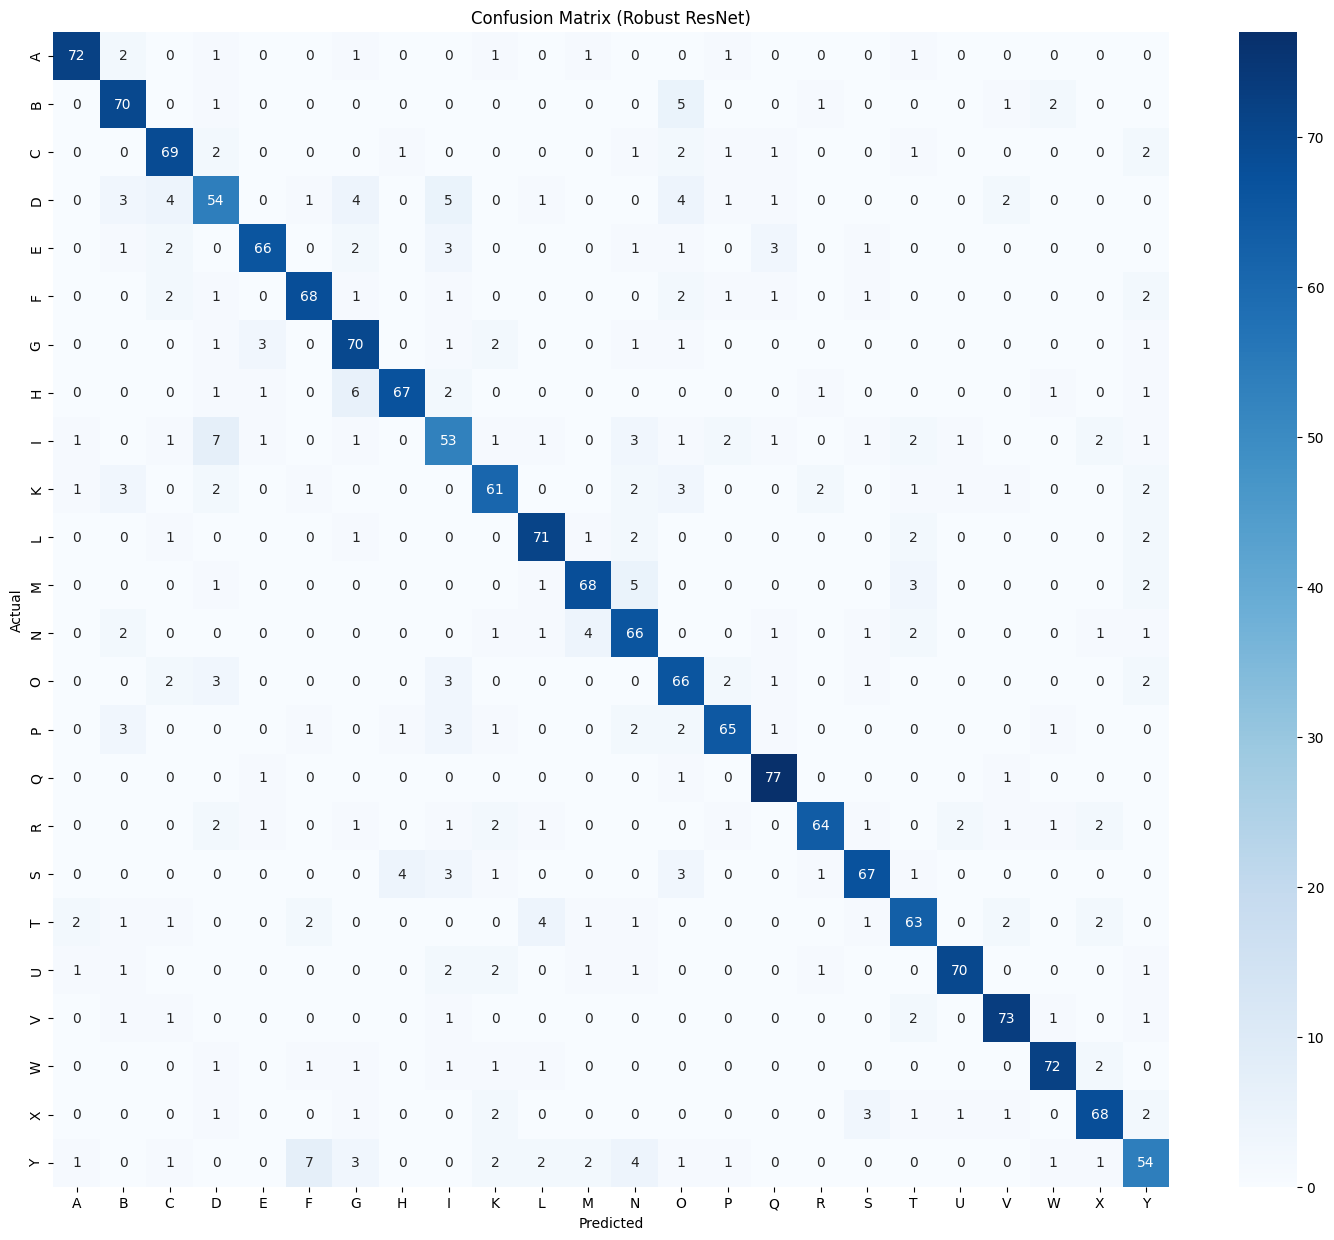


--- Classification Report ---
              precision    recall  f1-score   support

           A       0.92      0.90      0.91        80
           B       0.80      0.88      0.84        80
           C       0.82      0.86      0.84        80
           D       0.69      0.68      0.68        80
           E       0.90      0.82      0.86        80
           F       0.84      0.85      0.84        80
           G       0.76      0.88      0.81        80
           H       0.92      0.84      0.88        80
           I       0.67      0.66      0.67        80
           K       0.79      0.76      0.78        80
           L       0.86      0.89      0.87        80
           M       0.87      0.85      0.86        80
           N       0.74      0.82      0.78        80
           O       0.72      0.82      0.77        80
           P       0.87      0.81      0.84        80
           Q       0.89      0.96      0.92        80
           R       0.91      0.80      0.85       

In [20]:
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
plt.figure(figsize=(18, 15))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=encoder.classes_, 
            yticklabels=encoder.classes_)
plt.title('Confusion Matrix (Robust ResNet)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_classes, target_names=encoder.classes_))

In [21]:
model.save("asl_alphabet_model.h5")
model.save("asl_alphabet_model.keras")
print("Model saved successfully as 'asl_alphabet_model.h5'")
print("Model saved successfully as 'asl_alphabet_model.keras'")
np.save("encoder_classes.npy", encoder.classes_)

Model saved successfully as 'asl_alphabet_model.h5'
Model saved successfully as 'asl_alphabet_model.keras'
